<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/TStool/Custom_gluonts_Day3(3)_how_to_motify_the_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gluonts
!pip install mxnet-cu101

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 9.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 19 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
# Thanks https://github.com/iskra3138/GluonTS/blob/master/Custom_DeepFactor_YJ.ipynb


from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
#from gluonts.dataset.util import to_pandas

# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
#import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import json
#import os

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [4]:
dataset = get_dataset('electricity', regenerate=False)

In [9]:
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.evaluation import Evaluator

In [6]:
#1. A Trainer
# https://gluon-ts.mxnet.io/api/gluonts/gluonts.trainer.html
deepfactor_trainer=Trainer(
    ctx = 'gpu',
    epochs=10, # (default: 100).
    batch_size=32,# (default: 32).
    num_batches_per_epoch=50, # (default: 50).
    learning_rate=0.001, # (default:  10^−3 ).
    learning_rate_decay_factor=0.5, # (default: 0.5).
    patience = 10, # (default: 10).
    minimum_learning_rate=5e-05, # (default:  5⋅10^−5 ).
    clip_gradient = 10.0, # (default: 10).
    weight_decay=1e-08, #  (default  10^−8 ).
    init='xavier', #  (default: “xavier”).
    hybridize=True, 
    )

In [7]:
#2. A estimator
# change only context_length
DF_estimator = DeepFactorEstimator(
    freq=dataset.metadata.freq, # Time series frequency
    prediction_length=dataset.metadata.prediction_length, # Prediction length.
    num_hidden_global=50, # (default: 50).
    num_layers_global=1, # (default: 1).
    num_factors=10, # (default: 10).
    num_hidden_local=5, # (default: 5).
    num_layers_local=1, # (default: 1).
    cell_type='lstm', # (default: ‘lstm’).
    trainer = deepfactor_trainer, # (default: Trainer()).
    context_length=168, # (default: None, in which case context_length = prediction_length).
    num_parallel_samples=100, # (default: 100).
    cardinality=[int(dataset.metadata.feat_static_cat[0].cardinality)], # (default: list([1]).
    embedding_dimension=10, # (default: 10).
    #distr_output=StudentTOutput(), # (default: StudentTOutput()).
)

In [8]:
#3 A predictor
import os
import shutil
from pathlib import Path
model_path = "./pred"

DF_preditor = DF_estimator.train(dataset.train)
if os.path.exists(model_path):
    shutil.rmtree(model_path)
os.mkdir( model_path)
DF_preditor.serialize(Path(model_path))

100%|██████████| 50/50 [00:24<00:00,  2.01it/s, epoch=10/10, avg_epoch_loss=5.93e+5]


In [11]:
# Evaluation for all test data
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=DF_preditor, 
    num_samples=100, 
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

In [12]:
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 2247/2247 [00:00<00:00, 32727.72it/s]
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]


{
    "MSE": 47901432.450204276,
    "abs_error": 46742888.489993095,
    "abs_target_sum": 128632956.0,
    "abs_target_mean": 2385.272140631954,
    "seasonal_error": 189.49338196116761,
    "MASE": 3.3772847055112765,
    "MAPE": 0.42889130047025065,
    "sMAPE": 0.3423991491582906,
    "MSIS": 123.2416490212608,
    "QuantileLoss[0.1]": 34823777.33014339,
    "Coverage[0.1]": 0.39704791573950454,
    "QuantileLoss[0.5]": 46742888.62716517,
    "Coverage[0.5]": 0.4246958908173861,
    "QuantileLoss[0.9]": 58067823.314392194,
    "Coverage[0.9]": 0.4566458982346833,
    "RMSE": 6921.08607446868,
    "NRMSE": 2.901591795993143,
    "ND": 0.36338190416764654,
    "wQuantileLoss[0.1]": 0.27072204832285274,
    "wQuantileLoss[0.5]": 0.36338190523403013,
    "wQuantileLoss[0.9]": 0.45142259899859716,
    "mean_absolute_QuantileLoss": 46544829.75723358,
    "mean_wQuantileLoss": 0.36184218418516,
    "MAE_Coverage": 0.271902042229145,
    "OWA": NaN
}


/usr/local/lib/python3.7/dist-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)


In [15]:
def plot_prob_forecasts(ts_entry, forecast_entry, plot_length=150, prediction_intervals = (10.0, 75.0, 90.0)):
    
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

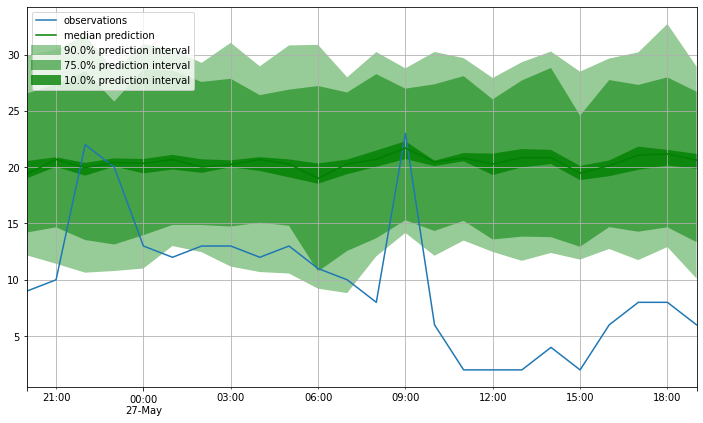

In [16]:
for i in range(1):
    plot_prob_forecasts(tss[i], forecasts[i], plot_length=dataset.metadata.prediction_length)

In [22]:
# 修改

# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License").
# You may not use this file except in compliance with the License.
# A copy of the License is located at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# or in the "license" file accompanying this file. This file is distributed
# on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
# express or implied. See the License for the specific language governing
# permissions and limitations under the License.

from functools import partial
from typing import List, Optional

from gluonts import transform
from gluonts.core.component import validated
from gluonts.dataset.common import Dataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import (
    DataLoader,
    TrainDataLoader,
    ValidationDataLoader,
)
from gluonts.env import env
from gluonts.model.predictor import Predictor
from gluonts.mx.batchify import batchify
from gluonts.mx.block.feature import FeatureEmbedder
from gluonts.mx.distribution import DistributionOutput, StudentTOutput
from gluonts.mx.model.estimator import GluonEstimator
from gluonts.mx.model.predictor import RepresentableBlockPredictor
from gluonts.mx.trainer import Trainer
from gluonts.mx.util import get_hybrid_forward_input_names
from gluonts.itertools import maybe_len
from gluonts.time_feature import time_features_from_frequency_str
from gluonts.transform import (
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    SelectFields,
    SetFieldIfNotPresent,
    TestSplitSampler,
    Transformation,
)

from gluonts.model.deep_factor.RNNModel import RNNModel
from gluonts.model.deep_factor._network import (
    DeepFactorTrainingNetwork,
    DeepFactorPredictionNetwork,
)


class custom_DeepFactorEstimator(GluonEstimator):
    r"""
    DeepFactorEstimator is an implementation of the 2019 ICML paper "Deep
    Factors for Forecasting" https://arxiv.org/abs/1905.12417.  It uses a
    global RNN model to learn patterns across multiple related time series and
    an arbitrary local model to model the time series on a per time series
    basis.  In the current implementation, the local model is a RNN (DF-RNN).
    Parameters
    ----------
    freq
        Time series frequency.
    prediction_length
        Prediction length.
    num_hidden_global
        Number of units per hidden layer for the global RNN model
        (default: 50).
    num_layers_global
        Number of hidden layers for the global RNN model (default: 1).
    num_factors
        Number of global factors (default: 10).
    num_hidden_local
        Number of units per hidden layer for the local RNN model (default: 5).
    num_layers_local
        Number of hidden layers for the global local model (default: 1).
    cell_type
        Type of recurrent cells to use (available: 'lstm' or 'gru';
        default: 'lstm').
    trainer
        Trainer object to be used (default: Trainer()).
    context_length
        Training length (default: None, in which case context_length =
        prediction_length).
    num_parallel_samples
        Number of evaluation samples per time series to increase parallelism
        during inference. This is a model optimization that does not affect the
        accuracy (default: 100).
    cardinality
        List consisting of the number of time series (default: list([1]).
    embedding_dimension
        Dimension of the embeddings for categorical features (the same
        dimension is used for all embeddings, default: 10).
    distr_output
        Distribution to use to evaluate observations and sample predictions
        (default: StudentTOutput()).
    batch_size
        The size of the batches to be used training and prediction.
    """

    @validated()
    def __init__(
        self,
        freq: str,
        prediction_length: int,
        num_hidden_global: int = 50,
        num_layers_global: int = 1,
        num_factors: int = 10,
        num_hidden_local: int = 5,
        num_layers_local: int = 1,
        cell_type: str = "lstm",
        trainer: Trainer = Trainer(),
        context_length: Optional[int] = None,
        num_parallel_samples: int = 100,
        cardinality: List[int] = list([1]),
        embedding_dimension: int = 10,
        distr_output: DistributionOutput = StudentTOutput(),
        batch_size: int = 32,
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)

        assert (
            prediction_length > 0
        ), "The value of `prediction_length` should be > 0"
        assert (
            context_length is None or context_length > 0
        ), "The value of `context_length` should be > 0"
        assert num_layers_global > 0, "The value of `num_layers` should be > 0"
        assert num_hidden_global > 0, "The value of `num_hidden` should be > 0"
        assert num_factors > 0, "The value of `num_factors` should be > 0"
        assert (
            num_hidden_local > 0
        ), "The value of `num_hidden_local` should be > 0"
        assert (
            num_layers_local > 0
        ), "The value of `num_layers_local` should be > 0"
        assert all(
            [c > 0 for c in cardinality]
        ), "Elements of `cardinality` should be > 0"
        assert (
            embedding_dimension > 0
        ), "The value of `embedding_dimension` should be > 0"
        assert (
            num_parallel_samples > 0
        ), "The value of `num_parallel_samples` should be > 0"

        self.freq = freq
        self.context_length = (
            context_length if context_length is not None else prediction_length
        )
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.num_parallel_samples = num_parallel_samples
        self.cardinality = cardinality
        self.embedding_dimensions = [embedding_dimension for _ in cardinality]

        self.global_model = RNNModel(
            mode=cell_type,
            num_hidden=num_hidden_global,
            num_layers=num_layers_global,
            num_output=num_factors,
        )

        # TODO: Allow the local model to be defined as an arbitrary local
        # model, e.g. DF-GP and DF-LDS
        self.local_model = RNNModel(
            mode=cell_type,
            num_hidden=num_hidden_local,
            num_layers=num_layers_local,
            num_output=1,
        )

    def create_transformation(self) -> Transformation:
        return Chain(
            trans=[
                AsNumpyArray(field=FieldName.TARGET, expected_ndim=1),
                AddTimeFeatures(
                    start_field=FieldName.START,
                    target_field=FieldName.TARGET,
                    output_field=FieldName.FEAT_TIME,
                    time_features=time_features_from_frequency_str(self.freq),
                    pred_length=self.prediction_length,
                ),
                SetFieldIfNotPresent(
                    field=FieldName.FEAT_STATIC_CAT, value=[0.0]
                ),
                AsNumpyArray(field=FieldName.FEAT_STATIC_CAT, expected_ndim=1),
            ]
        )

    def _create_instance_splitter(self, mode: str):
        return transform.InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            time_series_fields=[FieldName.FEAT_TIME],
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

    def create_training_data_loader(
        self,
        data: Dataset,
        **kwargs,
    ) -> DataLoader:
        input_names = get_hybrid_forward_input_names(DeepFactorTrainingNetwork)
        with env._let(max_idle_transforms=maybe_len(data) or 0):
            instance_splitter = self._create_instance_splitter("training")
        return TrainDataLoader(
            dataset=data,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            **kwargs,
        )

    def create_validation_data_loader(
        self,
        data: Dataset,
        **kwargs,
    ) -> DataLoader:
        input_names = get_hybrid_forward_input_names(DeepFactorTrainingNetwork)
        with env._let(max_idle_transforms=maybe_len(data) or 0):
            instance_splitter = self._create_instance_splitter("validation")
        return ValidationDataLoader(
            dataset=data,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
        )

    def create_training_network(self) -> DeepFactorTrainingNetwork:
        return DeepFactorTrainingNetwork(
            embedder=FeatureEmbedder(
                cardinalities=self.cardinality,
                embedding_dims=self.embedding_dimensions,
            ),
            global_model=self.global_model,
            local_model=self.local_model,
        )

    def create_predictor(
        self,
        transformation: Transformation,
        trained_network: DeepFactorTrainingNetwork,
    ) -> Predictor:
        prediction_splitter = self._create_instance_splitter("test")

        prediction_net = DeepFactorPredictionNetwork(
            embedder=trained_network.embedder,
            global_model=trained_network.global_model,
            local_model=trained_network.local_model,
            prediction_len=self.prediction_length,
            num_parallel_samples=self.num_parallel_samples,
            params=trained_network.collect_params(),
        )

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_net,
            batch_size=self.batch_size,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [23]:
# https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deep_factor.html
DF_estimator = custom_DeepFactorEstimator(
    freq=dataset.metadata.freq, # Time series frequency
    prediction_length=dataset.metadata.prediction_length, # Prediction length.
    num_hidden_global=50, # (default: 50).
    num_layers_global=1, # (default: 1).
    num_factors=10, # (default: 10).
    num_hidden_local=5, # (default: 5).
    num_layers_local=1, # (default: 1).
    cell_type='lstm', # (default: ‘lstm’).
    trainer = deepfactor_trainer, # (default: Trainer()).
    context_length=168, # (default: None, in which case context_length = prediction_length).
    num_parallel_samples=100, # (default: 100).
    cardinality=[int(dataset.metadata.feat_static_cat[0].cardinality)], # (default: list([1]).
    embedding_dimension=10, # (default: 10).
    #distr_output=StudentTOutput(), # (default: StudentTOutput()).
)

In [24]:
DF_predictor = DF_estimator.train(dataset.train)
# improve

100%|██████████| 50/50 [00:24<00:00,  2.03it/s, epoch=10/10, avg_epoch_loss=4.85e+5]


In [25]:
# Evaluation for all test data
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=DF_predictor, 
    num_samples=100, 
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 2247/2247 [00:00<00:00, 28697.49it/s]
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]


{
    "MSE": 49908790.887982406,
    "abs_error": 47600552.14626694,
    "abs_target_sum": 128632956.0,
    "abs_target_mean": 2385.272140631954,
    "seasonal_error": 189.49338196116761,
    "MASE": 3.3860095131290113,
    "MAPE": 0.41516170012069536,
    "sMAPE": 0.3427603599305783,
    "MSIS": 123.99430669699711,
    "QuantileLoss[0.1]": 33187447.248841744,
    "Coverage[0.1]": 0.3909101023587005,
    "QuantileLoss[0.5]": 47600551.84650176,
    "Coverage[0.5]": 0.42349058003263607,
    "QuantileLoss[0.9]": 61415228.17308751,
    "Coverage[0.9]": 0.45601542797804473,
    "RMSE": 7064.6154097716035,
    "NRMSE": 2.9617649447328493,
    "ND": 0.37004943077158964,
    "wQuantileLoss[0.1]": 0.2580011241352624,
    "wQuantileLoss[0.5]": 0.3700494284411979,
    "wQuantileLoss[0.9]": 0.4774455169411446,
    "mean_absolute_QuantileLoss": 47401075.75614367,
    "mean_wQuantileLoss": 0.3684986898392017,
    "MAE_Coverage": 0.2704680314493399,
    "OWA": NaN
}


/usr/local/lib/python3.7/dist-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)


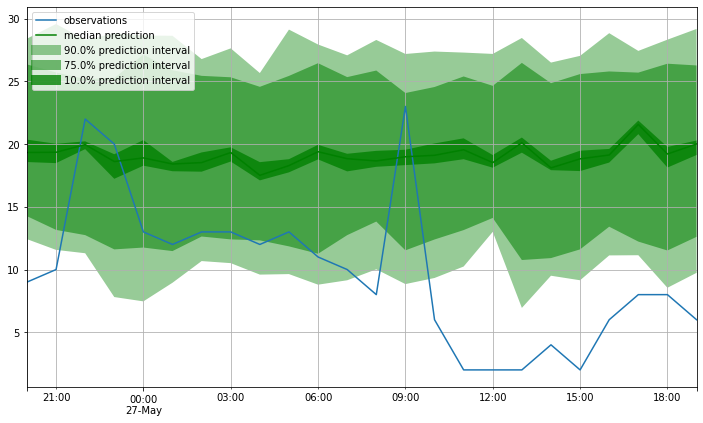

In [26]:
for i in range(1):
    plot_prob_forecasts(tss[i], forecasts[i], plot_length=dataset.metadata.prediction_length)

# gluonTS_lagged_value_share.ipynb

In [27]:
from pandas.tseries.frequencies import to_offset
import numpy as np

In [28]:
def _make_lags(middle: int, delta: int) -> np.ndarray:
    """
    Create a set of lags around a middle point including +/- delta
    """
    return np.arange(middle - delta, middle + delta + 1).tolist()

In [29]:
# Lags are target values at the same `season` (+/- delta) but in the previous cycle.
def _make_lags_for_minute(multiple, num_cycles=3):
    # We use previous ``num_cycles`` hours to generate lags
    return [
        _make_lags(k * 60 // multiple, 2) for k in range(1, num_cycles + 1)
    ]

def _make_lags_for_hour(multiple, num_cycles=7):
    # We use previous ``num_cycles`` days to generate lags
    return [
        _make_lags(k * 24 // multiple, 1) for k in range(1, num_cycles + 1)
    ]

def _make_lags_for_day(multiple, num_cycles=4):
    # We use previous ``num_cycles`` weeks to generate lags
    # We use the last month (in addition to 4 weeks) to generate lag.
    return [
        _make_lags(k * 7 // multiple, 1) for k in range(1, num_cycles + 1)
    ] + [_make_lags(30 // multiple, 1)]

def _make_lags_for_week(multiple, num_cycles=3):
    # We use previous ``num_cycles`` years to generate lags
    # Additionally, we use previous 4, 8, 12 weeks
    return [
        _make_lags(k * 52 // multiple, 1) for k in range(1, num_cycles + 1)
    ] + [[4 // multiple, 8 // multiple, 12 // multiple]]

def _make_lags_for_month(multiple, num_cycles=3):
    # We use previous ``num_cycles`` years to generate lags
    return [
        _make_lags(k * 12 // multiple, 1) for k in range(1, num_cycles + 1)
    ]

In [30]:
freq_str = '5min'

In [31]:
# multiple, granularity = get_granularity(freq_str)
offset = to_offset(freq_str)# pandas 함수, to_offset('5min') -> <5 * Minutes>

In [32]:
lags = (
            _make_lags_for_minute(offset.n)
            + _make_lags_for_hour(offset.n / 60.0)
            + _make_lags_for_day(offset.n / (60.0 * 24))
            + _make_lags_for_week(offset.n / (60.0 * 24 * 7))
        )

In [33]:
lags

[[10, 11, 12, 13, 14],
 [22, 23, 24, 25, 26],
 [34, 35, 36, 37, 38],
 [287.0, 288.0, 289.0],
 [575.0, 576.0, 577.0],
 [863.0, 864.0, 865.0],
 [1151.0, 1152.0, 1153.0],
 [1439.0, 1440.0, 1441.0],
 [1727.0, 1728.0, 1729.0],
 [2015.0, 2016.0, 2017.0],
 [2015.0, 2016.0, 2017.0],
 [4031.0, 4032.0, 4033.0],
 [6047.0, 6048.0, 6049.0],
 [8063.0, 8064.0, 8065.0],
 [8639.0, 8640.0, 8641.0],
 [104831.0, 104832.0, 104833.0],
 [209663.0, 209664.0, 209665.0],
 [314495.0, 314496.0, 314497.0],
 [8064.0, 16128.0, 24192.0]]

In [34]:
def _make_lags_for_minute(multiple, num_cycles=3):
    # We use previous ``num_cycles`` hours to generate lags
    return [
        _make_lags(k * 60 // multiple, 2) for k in range(1, num_cycles + 1)
    ]

print (offset.n) 
print ([(k * 60 // offset.n, 2) for k in range(1, 3 + 1)])
print ()

print (_make_lags_for_minute(offset.n)) 

5
[(12, 2), (24, 2), (36, 2)]

[[10, 11, 12, 13, 14], [22, 23, 24, 25, 26], [34, 35, 36, 37, 38]]


In [35]:
def _make_lags_for_hour(multiple, num_cycles=7):
    # We use previous ``num_cycles`` days to generate lags
    return [
        _make_lags(k * 24 // multiple, 1) for k in range(1, num_cycles + 1)
    ]
multiple = offset.n / 60.0 #(h)
num_cycles=7
print (multiple)
print ([(k * 24 // multiple, 1) for k in range(1, num_cycles + 1)])
print ([((k * 5 * 24 // multiple)/(60*24)  , 1) for k in range(1, num_cycles + 1)])
_make_lags_for_hour(offset.n / 60.0) 

0.08333333333333333
[(288.0, 1), (576.0, 1), (864.0, 1), (1152.0, 1), (1440.0, 1), (1728.0, 1), (2016.0, 1)]
[(1.0, 1), (2.0, 1), (3.0, 1), (4.0, 1), (5.0, 1), (6.0, 1), (7.0, 1)]


[[287.0, 288.0, 289.0],
 [575.0, 576.0, 577.0],
 [863.0, 864.0, 865.0],
 [1151.0, 1152.0, 1153.0],
 [1439.0, 1440.0, 1441.0],
 [1727.0, 1728.0, 1729.0],
 [2015.0, 2016.0, 2017.0]]

In [36]:
def _make_lags_for_day(multiple, num_cycles=4):
    # We use previous ``num_cycles`` weeks to generate lags
    # We use the last month (in addition to 4 weeks) to generate lag.
    return [
        _make_lags(k * 7 // multiple, 1) for k in range(1, num_cycles + 1)
    ] + [_make_lags(30 // multiple, 1)]

multiple = offset.n / (60.0 * 24)
num_cycles=4
print (multiple)
print ([(k * 7 // multiple, 1) for k in range(1, num_cycles + 1)])   

_make_lags_for_day(offset.n / (60.0 * 24))

0.003472222222222222
[(2016.0, 1), (4032.0, 1), (6048.0, 1), (8064.0, 1)]


[[2015.0, 2016.0, 2017.0],
 [4031.0, 4032.0, 4033.0],
 [6047.0, 6048.0, 6049.0],
 [8063.0, 8064.0, 8065.0],
 [8639.0, 8640.0, 8641.0]]

In [37]:
def _make_lags_for_week(multiple, num_cycles=3):
    # We use previous ``num_cycles`` years to generate lags
    # Additionally, we use previous 4, 8, 12 weeks
    return [
        _make_lags(k * 52 // multiple, 1) for k in range(1, num_cycles + 1)
    ] + [[4 // multiple, 8 // multiple, 12 // multiple]]

multiple = offset.n / (60.0 * 24 * 7)
num_cycles=3
print (multiple)
print ([(k * 52 // multiple, 1) for k in range(1, num_cycles + 1)])  

_make_lags_for_week(offset.n / (60.0 * 24 * 7))

0.000496031746031746
[(104832.0, 1), (209664.0, 1), (314496.0, 1)]


[[104831.0, 104832.0, 104833.0],
 [209663.0, 209664.0, 209665.0],
 [314495.0, 314496.0, 314497.0],
 [8064.0, 16128.0, 24192.0]]

In [ ]:
#get_lagged_subseuences


# https://github.com/iskra3138/GluonTS/blob/master/gluonTS_lagged_value_share.ipynb